In [1]:
import sys
import numpy as np
import time
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

plt.rcParams['image.cmap'] = 'coolwarm'


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
map_size = 256
n_test = int(2000)
n_epoch = 50
batch_size = 32
learning_rate = 1e-4

foreground_amplitude_rescale = 253775.
T_mean_cmb = 2.726*1e6

In [4]:
target = np.load('../../polarized_synthesis/data/sim_QiU_stdr_3.npy').real
M,N=target.shape[0], target.shape[1]
mean = np.mean(target)
std = np.std(target)
target = ((target - mean)/(std*20)) + 1.

files = [filename for filename in os.listdir('../../polarized_synthesis/long_run/') if '.npy' in filename]
print(files)
nfiles=len(files)
print(nfiles)

['long_run103npy.npy', 'long_run216npy.npy', 'long_run200npy.npy', 'long_run2npy.npy', 'long_run240npy.npy', 'long_run115npy.npy', 'long_run237npy.npy', 'long_run221npy.npy', 'long_run214npy.npy', 'long_run15npy.npy', 'long_run101npy.npy', 'long_run219npy.npy', 'long_run242npy.npy', 'long_run0npy.npy', 'long_run202npy.npy', 'long_run235npy.npy', 'long_run238npy.npy', 'long_run223npy.npy', 'long_run111npy.npy', 'long_run244npy.npy', 'long_run204npy.npy', 'long_run6npy.npy', 'long_run212npy.npy', 'long_run209npy.npy', 'long_run107npy.npy', 'long_run13npy.npy', 'long_run249npy.npy', 'long_run225npy.npy', 'long_run233npy.npy', 'long_run228npy.npy', 'long_run4npy.npy', 'long_run206npy.npy', 'long_run108npy.npy', 'long_run246npy.npy', 'long_run113npy.npy', 'long_run11npy.npy', 'long_run105npy.npy', 'long_run9npy.npy', 'long_run210npy.npy', 'long_run227npy.npy', 'long_run231npy.npy', 'long_run232npy.npy', 'long_run229npy.npy', 'long_run224npy.npy', 'long_run213npy.npy', 'long_run12npy.npy', '

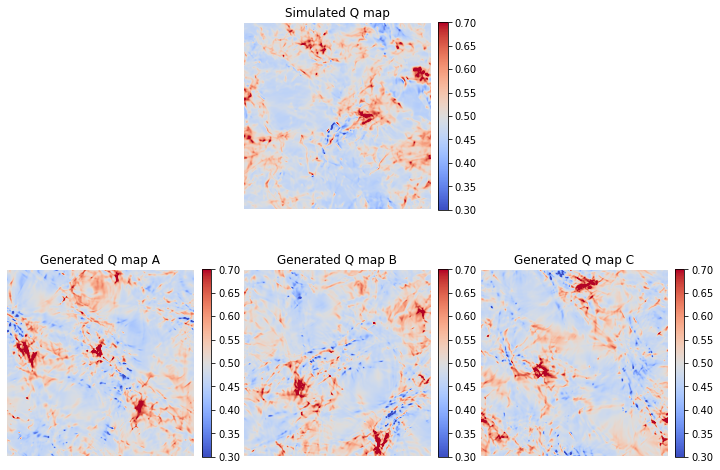

In [5]:
input_foreground_array = np.empty((nfiles,512,512), dtype=np.float32)
data_array_low_res = np.empty((nfiles,128,128), dtype=np.complex64)
for i in range(nfiles):
#     print(i)
    input_foreground_array[i] = ((np.load('../../polarized_synthesis/long_run/' + files[i]).real- mean)/(std*20.))  +1.
    data_array_low_res[i] = input_foreground_array[i].reshape(128, 4, 128, 4).mean(axis=(1, 3))
    
_ = plt.figure(figsize=(10,7))
_ = plt.subplot(2,3,2), plt.imshow(ndimage.gaussian_filter(target,1)-0.5, clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Simulated Q map'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,4), plt.imshow(ndimage.gaussian_filter(tf.image.rot90(input_foreground_array-0.5,k=2)[0,:,:],1).T,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Generated Q map A'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,5), plt.imshow(ndimage.gaussian_filter(input_foreground_array[1,:,:].T,1)-0.5,
                                   clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Generated Q map B'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,6), plt.imshow(ndimage.gaussian_filter(tf.image.rot90(input_foreground_array-0.5,2)[5,:,:],1),
                                   clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Generated Q map C'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('Q_map.png',dpi=200)

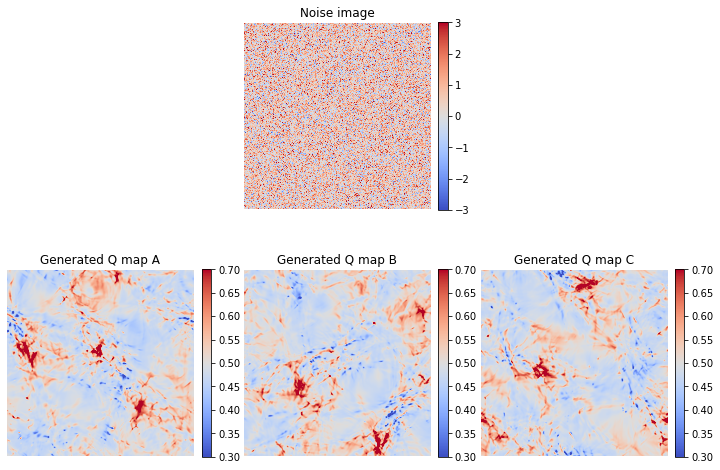

In [6]:

_ = plt.figure(figsize=(10,7))
_ = plt.subplot(2,3,2), plt.imshow(np.random.normal(0.5,1,target.shape), clim=(-3,3),
                                   interpolation='None', cmap = 'coolwarm')
_ = plt.title('Noise image'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,4), plt.imshow(ndimage.gaussian_filter(tf.image.rot90(input_foreground_array-0.5,k=2)[0,:,:],1).T,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Generated Q map A'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,5), plt.imshow(ndimage.gaussian_filter(input_foreground_array[1,:,:].T,1)-0.5,
                                   clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Generated Q map B'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,3,6), plt.imshow(ndimage.gaussian_filter(tf.image.rot90(input_foreground_array-0.5,2)[5,:,:],1),
                                   clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Generated Q map C'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('Q_maps_noise.png',dpi=200)

In [7]:
for i in range(input_foreground_array.shape[0]):
    if i%(int(input_foreground_array.shape[0]/10))==0: print(i, flush=True)
    input_foreground_array[i,:,:] = ndimage.gaussian_filter(input_foreground_array[i,:,:], 1) 
    
input_foreground_array = np.expand_dims(input_foreground_array, 3)

rotated_foreground_array = np.copy(input_foreground_array)
for i in range(3):
    rotated_foreground_array = np.concatenate([rotated_foreground_array,
                                               tf.image.rot90(input_foreground_array, k = i+1)])

rotated_foreground_array = np.concatenate([rotated_foreground_array,
                                           tf.image.transpose(rotated_foreground_array)])
print(rotated_foreground_array.shape)
gc.collect()

0
8
16
24
32
40
48
56
64
72
80
(656, 512, 512, 1)


33172

In [1]:
rotated_foreground_array.shape

NameError: name 'rotated_foreground_array' is not defined

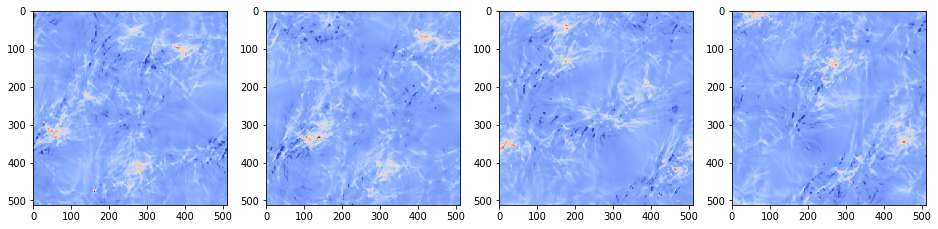

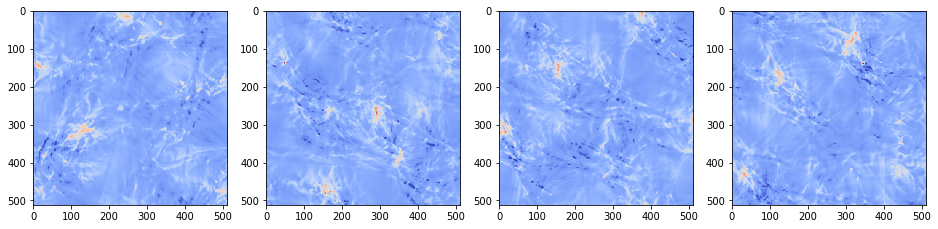

In [8]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(rotated_foreground_array[i*20,:,:,0], clim=(0.8,1.6))
plt.show()

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(rotated_foreground_array[i*20+80,:,:,0], clim=(0.8,1.6))
plt.show()

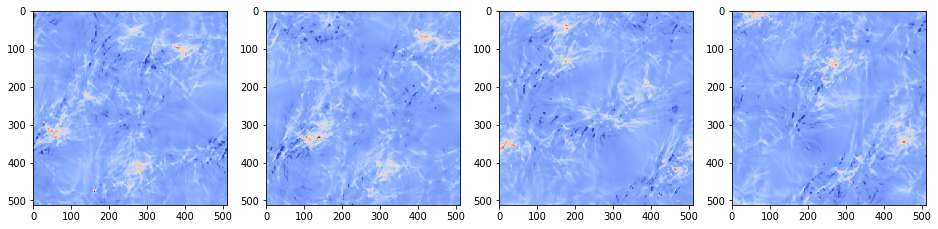

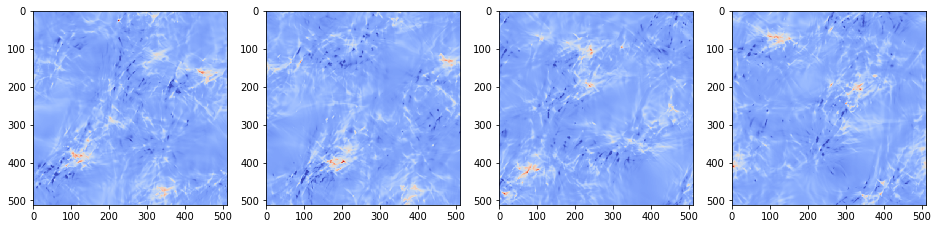

In [9]:
test = np.roll(np.roll(rotated_foreground_array, shift=64,axis=1),shift=64,axis=2)

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(rotated_foreground_array[i*20,:,:,0], clim=(0.8,1.6))
plt.show()

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(test[i*20,:,:,0], clim=(0.8,1.6))
plt.show()

In [10]:
n_step = 8
grid_step = np.meshgrid(np.linspace(0,N,n_step+1, dtype=int)[:-1],np.linspace(0,M,n_step+1, dtype=int)[:-1])
grid_i_index = grid_step[0].flatten()
grid_j_index = grid_step[1].flatten()

noisy_array = np.empty((len(grid_i_index)*rotated_foreground_array.shape[0], map_size,map_size,1), dtype=np.float32)
print(noisy_array.shape)

for i in range(len(grid_i_index)):
    low_lim = i*rotated_foreground_array.shape[0]
    high_lim = (i+1)*rotated_foreground_array.shape[0]
    noisy_array[low_lim:high_lim] = np.roll(np.roll(rotated_foreground_array, shift=grid_i_index[i],axis=1),
                                            shift=grid_j_index[i],axis=2)[:,:int(N/2),:int(M/2),:]
    print(grid_i_index[i], grid_j_index[i])
    
#     plt.imshow(noisy_array[low_lim,:,:,0], clim=(0.8,1.2)), plt.show()

noisy_array = (noisy_array - np.mean(noisy_array))/(20*np.std(noisy_array))

random_indices = np.arange(noisy_array.shape[0])
np.random.shuffle(random_indices)

noisy_array = noisy_array[random_indices]

(41984, 256, 256, 1)
0 0
64 0
128 0
192 0
256 0
320 0
384 0
448 0
0 64
64 64
128 64
192 64
256 64
320 64
384 64
448 64
0 128
64 128
128 128
192 128
256 128
320 128
384 128
448 128
0 192
64 192
128 192
192 192
256 192
320 192
384 192
448 192
0 256
64 256
128 256
192 256
256 256
320 256
384 256
448 256
0 320
64 320
128 320
192 320
256 320
320 320
384 320
448 320
0 384
64 384
128 384
192 384
256 384
320 384
384 384
448 384
0 448
64 448
128 448
192 448
256 448
320 448
384 448
448 448


In [11]:
files = sorted(os.listdir('../../polarized_synthesis/data/cmb_signal/maps/'))
full_path_files = [('../../polarized_synthesis/data/cmb_signal/maps/' + file) for file in files if '.npy' in file]
print(len(full_path_files))

n_files = 41984
clean_array = np.stack([np.load(f).transpose(1,2,0) for f in full_path_files[:n_files]])[:,:,:,0]
clean_array = clean_array.reshape(n_files,256,256,1)
gc.collect()

43200


36073

In [12]:
for i in range(clean_array.shape[0]):
    if i%(int(clean_array.shape[0]/50))==0: print(i, flush=True)
    clean_array[i,:,:,0] = ndimage.gaussian_filter(clean_array[i,:,:,0], 1)
    clean_array[i,:,:,0] = (clean_array[i,:,:,0] - np.mean(clean_array[i,:,:,0]))*np.random.normal(1,0.1) + clean_array[i,:,:,0]
gc.collect()

# clean_array = clean_array[:,:map_size,:map_size,:]
clean_array = (clean_array - np.mean(clean_array))/(30*np.std(clean_array)) + 0.5
noisy_array = noisy_array[:n_files] + clean_array #+ 0.1

test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

0
839
1678
2517
3356
4195
5034
5873
6712
7551
8390
9229
10068
10907
11746
12585
13424
14263
15102
15941
16780
17619
18458
19297
20136
20975
21814
22653
23492
24331
25170
26009
26848
27687
28526
29365
30204
31043
31882
32721
33560
34399
35238
36077
36916
37755
38594
39433
40272
41111
41950


0

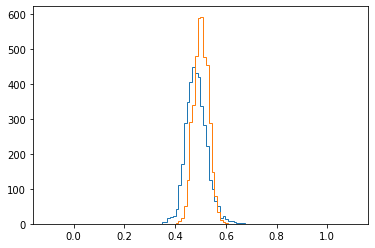

In [13]:
_ = plt.hist(noisy_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
_ = plt.hist(clean_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

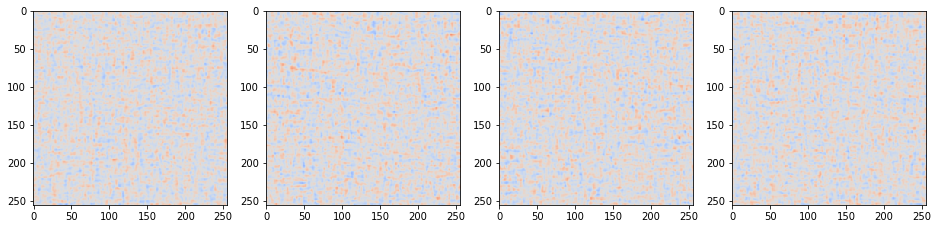

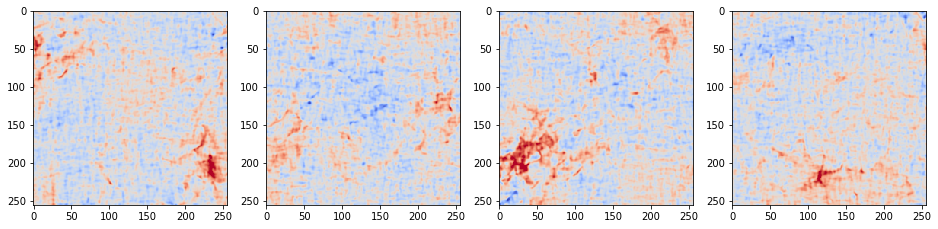

In [14]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(clean_array[i*20,:,:,0], clim=(0.2, 0.8))
plt.show()

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(noisy_array[i*20,:,:,0], clim=(0.2,0.8))
plt.show()

In [15]:
train_gen = cnn.BatchGenerator(noisy_array, clean_array, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_array_clean, gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch*2,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)), verbose=True)

gc.collect()

Epoch 1/100


/obs/njeffrey/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1250/1250 [==============================] - 307s 67ms/step - loss: 0.0059 - val_loss: 5.1959e-04
Epoch 2/100
1250/1250 [==============================] - 80s 64ms/step - loss: 4.1906e-04 - val_loss: 3.5356e-04
Epoch 3/100
1250/1250 [==============================] - 80s 64ms/step - loss: 3.2949e-04 - val_loss: 3.1456e-04
Epoch 4/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.9745e-04 - val_loss: 2.8817e-04
Epoch 5/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.7848e-04 - val_loss: 2.7716e-04
Epoch 6/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.6637e-04 - val_loss: 2.6379e-04
Epoch 7/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.5633e-04 - val_loss: 2.5444e-04
Epoch 8/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.4919e-04 - val_loss: 2.4573e-04
Epoch 9/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.4377e-04 - val_loss: 2.4320e-0

1250/1250 [==============================] - 80s 64ms/step - loss: 2.0617e-04 - val_loss: 2.0730e-04
Epoch 74/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0588e-04 - val_loss: 2.0715e-04
Epoch 75/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0672e-04 - val_loss: 2.0687e-04
Epoch 76/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0600e-04 - val_loss: 2.0672e-04
Epoch 77/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0556e-04 - val_loss: 2.0658e-04
Epoch 78/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0568e-04 - val_loss: 2.0745e-04
Epoch 79/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0525e-04 - val_loss: 2.0610e-04
Epoch 80/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0509e-04 - val_loss: 2.0684e-04
Epoch 81/100
1250/1250 [==============================] - 80s 64ms/step - loss: 2.0519e-04 - val_loss

50

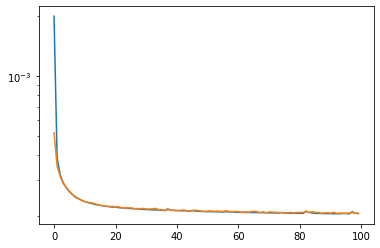

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [18]:
test_output = cnn_model.predict(noisy_array[10000:10002])

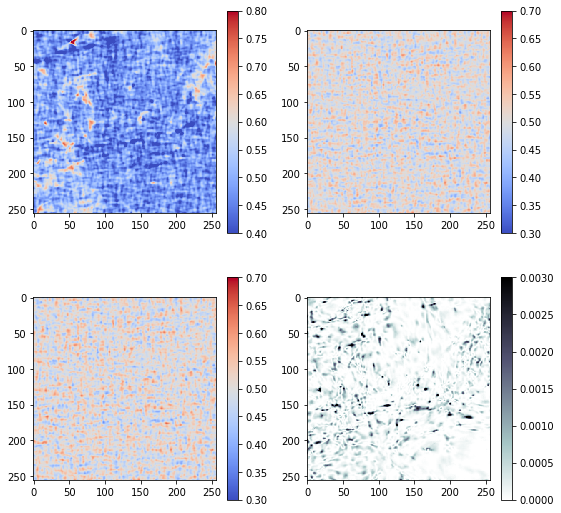

In [19]:
_ = plt.figure(figsize=(9,9))
_ = plt.subplot(221), plt.imshow(noisy_array[10000,:,:,0], clim=(0.4,0.8)), plt.colorbar()
_ = plt.subplot(222), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7)), plt.colorbar()
_ = plt.subplot(223), plt.imshow(clean_array[10000,:,:,0], clim=(0.3,0.7)), plt.colorbar()
_ = plt.subplot(224), plt.imshow((clean_array[10000,:,:,0]-test_output[0,:,:,0])**2, clim=(0,3e-3), cmap='bone_r')
_ = plt.colorbar()

In [ ]:
target_var = 100*(cnn_model.predict(noisy_array) - clean_array)**2.
_ = plt.hist(target_var[0,:,:,0].flatten(),bins=np.linspace(-0.1,1.1,111), histtype='step')

In [ ]:
train_gen_var = cnn.BatchGenerator(noisy_array[:10000], target_var[:10000], gen_batch_size=batch_size)
test_gen_var = cnn.BatchGenerator(noisy_array[10000:], target_var[10000:], gen_batch_size=batch_size)

cnn_instance_var = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model_var = cnn_instance_var.model()

In [ ]:
history_var = cnn_model_var.fit_generator(generator=train_gen_var,
                         epochs=20,
                         steps_per_epoch=np.ceil(noisy_array[:10000].shape[0] / int(batch_size)),
                         validation_data=test_gen_var,
                         validation_steps=np.ceil(noisy_array[10000:].shape[0] / int(batch_size)), verbose=True)

gc.collect()

In [ ]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.yscale('log')

In [ ]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.ylim(2.4e-3,2.8e-3)

In [ ]:
test_var = cnn_model_var.predict(noisy_array[10000:10002])

In [ ]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(noisy_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $I$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[10001,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $II$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(noisy_array[10002,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $III$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('foreground_data_examples_Q.png', dpi=300)

In [ ]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(clean_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Target signal Q(ish)'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_pol_!.png', dpi=300)

In [ ]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1),  plt.imshow(noisy_array[10000,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_var[0,:,:,0]/100., clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(Q | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_pol_Q.png', dpi=300)

In [ ]:
input_patch_example = ndimage.gaussian_filter(target, 1)
input_patch_example = (input_patch_example - np.mean(input_patch_example))/(20*np.std(input_patch_example))
input_patch_example = np.reshape(input_patch_example[128:-128,128:-128], (1,256,256,1))
input_signal_example = np.reshape(test_array_clean[0], (1,256,256,1))
input_patch_example = input_patch_example + input_signal_example 

In [ ]:
# _ = plt.hist(noisy_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
# _ = plt.hist(clean_array.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

In [ ]:
# _ = plt.hist(input_patch_example.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')
# _ = plt.hist(input_signal_example.flatten()[:4000], bins=np.linspace(-0.1,1.1,111), histtype='step')

In [ ]:
plt.imshow(input_patch_example[0,:,:,0]-input_signal_example[0,:,:,0]+0.5, clim=(0.4,0.8))

In [ ]:
test_output = cnn_model.predict(input_patch_example)
test_var = cnn_model_var.predict(input_patch_example)

In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.suptitle(r'Simulated (original) data', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_example[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_example[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(test_output[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(test_var[0,5:-5,5:-5,0]/100., clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(T | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.tight_layout(True)
_ = plt.savefig('reconstruction_var_pol_Q.png', dpi=300)

In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.suptitle('Simulated (original) data', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_example[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_example[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(test_output[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(input_signal_example[0,5:-5,5:-5,0]- test_output[0,5:-5,5:-5,0], clim=(-0.1,0.1),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Residuals'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('reconstruction_var_pol3_Q.png', dpi=300)

In [ ]:
mse_original = np.mean((test_output[0,5:-5,5:-5,0] - input_signal_example[0,5:-5,5:-5,0]).flatten()**2.)
print(mse_original)

In [ ]:
_ = plt.figure(figsize=(13,10))
_ = plt.suptitle('Planck data (trained with WPH)', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_example[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_example[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(test_output[0,5:-5,5:-5,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(np.sqrt((input_signal_example[0,5:-5,5:-5,0]-test_output[0,5:-5,5:-5,0])**2),
                                   interpolation='spline16',cmap = 'viridis')
_ = plt.title(r'sqrt(Residual$^2)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_pol2_Q.png', dpi=300)

In [ ]:
from astropy.io import fits

In [ ]:
Q_alt = np.array(fits.open('../../polarized_synthesis/data/alternative/Q_y0_z_output_00071.fits')[0].data).astype(np.float32)
U_alt = np.array(fits.open('../../polarized_synthesis/data/alternative/U_y0_z_output_00071.fits')[0].data).astype(np.float32)

In [ ]:
input_patch_validation = ndimage.gaussian_filter(Q_alt, 1)
input_patch_validation = (input_patch_validation - np.mean(input_patch_validation))/(20*np.std(input_patch_validation))
input_patch_validation = np.reshape(input_patch_validation[:256,128:-128], (1,256,256,1))
input_signal_validation = np.reshape(test_array_clean[0], (1,256,256,1))
input_patch_validation = input_patch_validation + input_signal_example 

plt.imshow(input_patch_validation[0,:,:,0]-input_signal_validation[0,:,:,0]+0.5), plt.colorbar()

In [ ]:
plt.imshow(input_patch_validation[0,:,:,0]), plt.colorbar()

In [ ]:
_ = plt.hist((input_patch_validation[0,:256,:256,0]-input_signal_validation[0,:256,:256,0]+0.5).flatten(), bins=np.linspace(0.0,1,64))
_ = plt.hist(target[:256,:256].flatten()-0.5, bins=np.linspace(-0.0,1,64), histtype='step')

In [ ]:
valid_output = cnn_model.predict(input_patch_validation)
valid_var = cnn_model_var.predict(input_patch_validation)

In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.suptitle(r'Simulated (unseen) data', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(valid_output[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(valid_var[0,5:-5,5:-5,0]/100., clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(Q | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('reconstruction_var_pol_valid_Q.png', dpi=300)


In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.suptitle(r'Simulated (unseen) data', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(valid_output[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(valid_output[0,5:-5,5:-5,0] - input_signal_validation[0,5:-5,5:-5,0], clim=(-0.15,0.15),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Residual'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('reconstruction_var_pol_residual_Q.png', dpi=300)

In [ ]:
residuals  = (valid_output[0,5:-5,5:-5,0] - input_signal_validation[0,5:-5,5:-5,0]).flatten()
sigma = np.sqrt(valid_var[0,5:-5,5:-5,0]/100.).flatten()

In [ ]:
_ = plt.hist(residuals/sigma, bins=np.linspace(-6,6,65), histtype='step')

In [ ]:
gaussian_samples = np.random.normal(0,1,int(1e7))

In [ ]:
_ = plt.hist(residuals/sigma, bins=np.linspace(-6.5,6.5,64), color='C2', density=True, alpha=0.5,label=r'$(\mu - s)/\sigma$')
_ = plt.hist(gaussian_samples, bins=np.linspace(-6.5,6.5,256), histtype='step', density=True, label='Normal (target)')
_ = plt.legend(fontsize=12.), plt.savefig('validation_residuals_Q.png',dpi=100)

In [ ]:
_ = plt.hist(residuals/sigma, bins=np.linspace(-6.5,6.5,256), color='C2', density=True, alpha=0.5,label=r'$(\mu - s)/\sigma$')
_ = plt.hist(gaussian_samples, bins=np.linspace(-6.5,6.5,256), histtype='step', density=True, label='Normal (target)')
_ = plt.legend(fontsize=12.), plt.savefig('validation_residuals_Q.png',dpi=100)

In [ ]:
np.std(residuals/sigma)

In [ ]:
np.sqrt(np.mean((residuals/sigma)**2.))

In [ ]:
np.mean(residuals/sigma)

In [ ]:
mse_unseen = np.mean((valid_output[0,5:-5,5:-5,0] - input_signal_validation[0,5:-5,5:-5,0]).flatten()**2.)
print(mse_unseen)

In [ ]:
foreground_power = input_patch_validation[0,:,:,0] - input_signal_validation[0,:,:,0]
foreground_power = foreground_power - np.mean(foreground_power)
foreground_power = np.fft.fftshift(np.fft.fft2(foreground_power))
foreground_power = mf.radial_profile(np.real(foreground_power*np.conj(foreground_power)))

In [ ]:
signal_power = input_signal_validation[0,:,:,0] - 0.5
signal_power = signal_power - np.mean(signal_power)
signal_power = np.fft.fftshift(np.fft.fft2(signal_power))
signal_power = mf.radial_profile(np.real(signal_power*np.conj(signal_power)))

In [ ]:
wiener = signal_power/(foreground_power+signal_power)
wiener = np.fft.fftshift(mf.compute_spectrum_map(wiener, 256))
wiener_data = test_array_noisy[0,:,:,0]-0.5 - np.mean(test_array_noisy[0,:,:,0]-0.5)
wiener_filter = np.fft.ifft2(np.fft.fft2(wiener_data)*wiener).real

In [ ]:
cov_ft = 1.0/(1./foreground_power + 1./signal_power)
cov_ft = np.fft.fftshift(mf.compute_spectrum_map(cov_ft, 256))

In [ ]:
gaussian_mock = np.random.normal(0, np.sqrt(2.*mf.compute_spectrum_map(signal_power, 256).flatten()))
gaussian_mock = np.fft.ifft2(np.fft.fftshift(gaussian_mock.reshape((256,256)))).real*256.

In [ ]:
plt.imshow(gaussian_mock), plt.colorbar()

In [ ]:
var_image = gaussian_mock*0.
n=10000
for i in range(n):
    posterior_realisation = np.random.normal(0, np.sqrt(cov_ft.flatten()))
    posterior_realisation = np.abs(np.fft.fftshift(np.fft.ifft2((posterior_realisation.reshape((256,256))))))*256
    var_image += posterior_realisation*posterior_realisation/np.float(n)
    
std_image = np.sqrt(var_image)
np.mean(std_image)

In [ ]:
np.mean(var_image)

In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.suptitle(r'Simulated (unseen) data', fontsize=16)
_ = plt.subplot(2,2,1),  plt.imshow(input_patch_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,2),  plt.imshow(input_signal_validation[0,5:-5,5:-5,0], clim=(0.35,0.65),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('True signal'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,3), plt.imshow(wiener_filter[5:-5,5:-5]+0.5, clim=(0.35,0.65),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$ \n Gaussian prior & power spectrum'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(2,2,4), plt.imshow(var_image[5:-5,5:-5], clim = (0.,1e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(Q | d)$ variance \n Gaussian prior & power spectrum'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True)
_ = plt.savefig('reconstruction_var_pol_wiener_Q.png', dpi=300)


In [ ]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow((test_array_noisy[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.15*0.3,0.2*0.3),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow((wiener_filter[:,:])*3e5*1e-6, clim=(-0.1*0.3,0.1*0.3),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Gaussian model $p(T | d)$ mean'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3),  plt.imshow(std_image*0.+np.mean(std_image), clim = (1e-7,1e-3),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Gaussian model $p(T | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('W_reconstruction_var_wiener_Q.png', dpi=300)